## Interpretation

This notebook will cover permutation importance and SHAP to explore the models' results and how each feature affects the models' predictions.

- Explain difference between permutation importance and SHAP (local and global)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
import pickle
import tensorflow as tf

In [2]:
# Read the data and re-create the train-test split
df = pd.read_csv("../data/processed/nhanes_data_processed_label_encoded.csv")

X = df.drop("diabetes", axis=1)
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

with open("../models/metadata.pkl", "rb") as f:
    metadata = pickle.load(f)
    print("Loaded metadata")
feature_names = metadata["feature_names"]

RANDOM_STATE = 42

Loaded metadata


In [3]:
# Load models
dt_model = joblib.load('../models/decision_tree_model.pkl')
rf_model = joblib.load('../models/random_forest_model.pkl')
xgb_model = joblib.load('../models/xgboost_model.pkl')
adb_model = joblib.load('../models/adaboost_model.pkl')
lgr_model = joblib.load('../models/logistic_regression_model.pkl')
knn_model = joblib.load('../models/k-nearest_neighbors_model.pkl')
svc_model = joblib.load('../models/support_vector_machine_model.pkl')
nn_model = tf.keras.models.load_model("../models/neural_network_model.keras", compile=True)

models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "AdaBoost": adb_model,
    "Logistic Regression": lgr_model,
    "K-Nearest Neighbors": knn_model,
    "Support Vector Machine": svc_model,
    "Neural Network": nn_model
}

In [4]:
# Extract scaler from pipeline models
lgr_scaler = lgr_model.named_steps["standardscaler"]
X_train_scaled = lgr_scaler.transform(X_train)
X_test_scaled = lgr_scaler.transform(X_test)

## Permutation Importance

- explain permutation importance

In [5]:
from sklearn.inspection import permutation_importance

In [6]:
# Create a wrapper class for the neural network model to use with sklearn
from sklearn.base import BaseEstimator

class NeuralNetworkWrapper(BaseEstimator):
    def __init__(self, model, scaler=None):
        self.model = model
        self.scaler = scaler
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        """Return class predictions"""
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
            
        logits = self.model.predict(X_scaled, verbose=0)
        return np.argmax(logits, axis=1)
    
    def predict_proba(self, X):
        """Return class probabilities"""
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
            
        logits = self.model.predict(X_scaled, verbose=0)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [7]:
# Calculate permutation importance for each model
perm_importance_results = {}

for model_name, model in models.items():
    if model_name != "Neural Network":
        perm_result = permutation_importance(model, X_test, y_test,
                                            scoring="f1_macro",
                                            n_repeats=10,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
    else:
        nn_wrapper = NeuralNetworkWrapper(nn_model)
        perm_result = permutation_importance(nn_wrapper, X_test_scaled, y_test,
                                            scoring="f1_macro",
                                            n_repeats=10,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
    perm_importance_results[model_name] = pd.DataFrame({"feature" : feature_names,
                                                            "importance_mean": perm_result.importances_mean,
                                                            "importance_std": perm_result.importances_std,                       
                                }).sort_values("importance_mean", ascending=False)

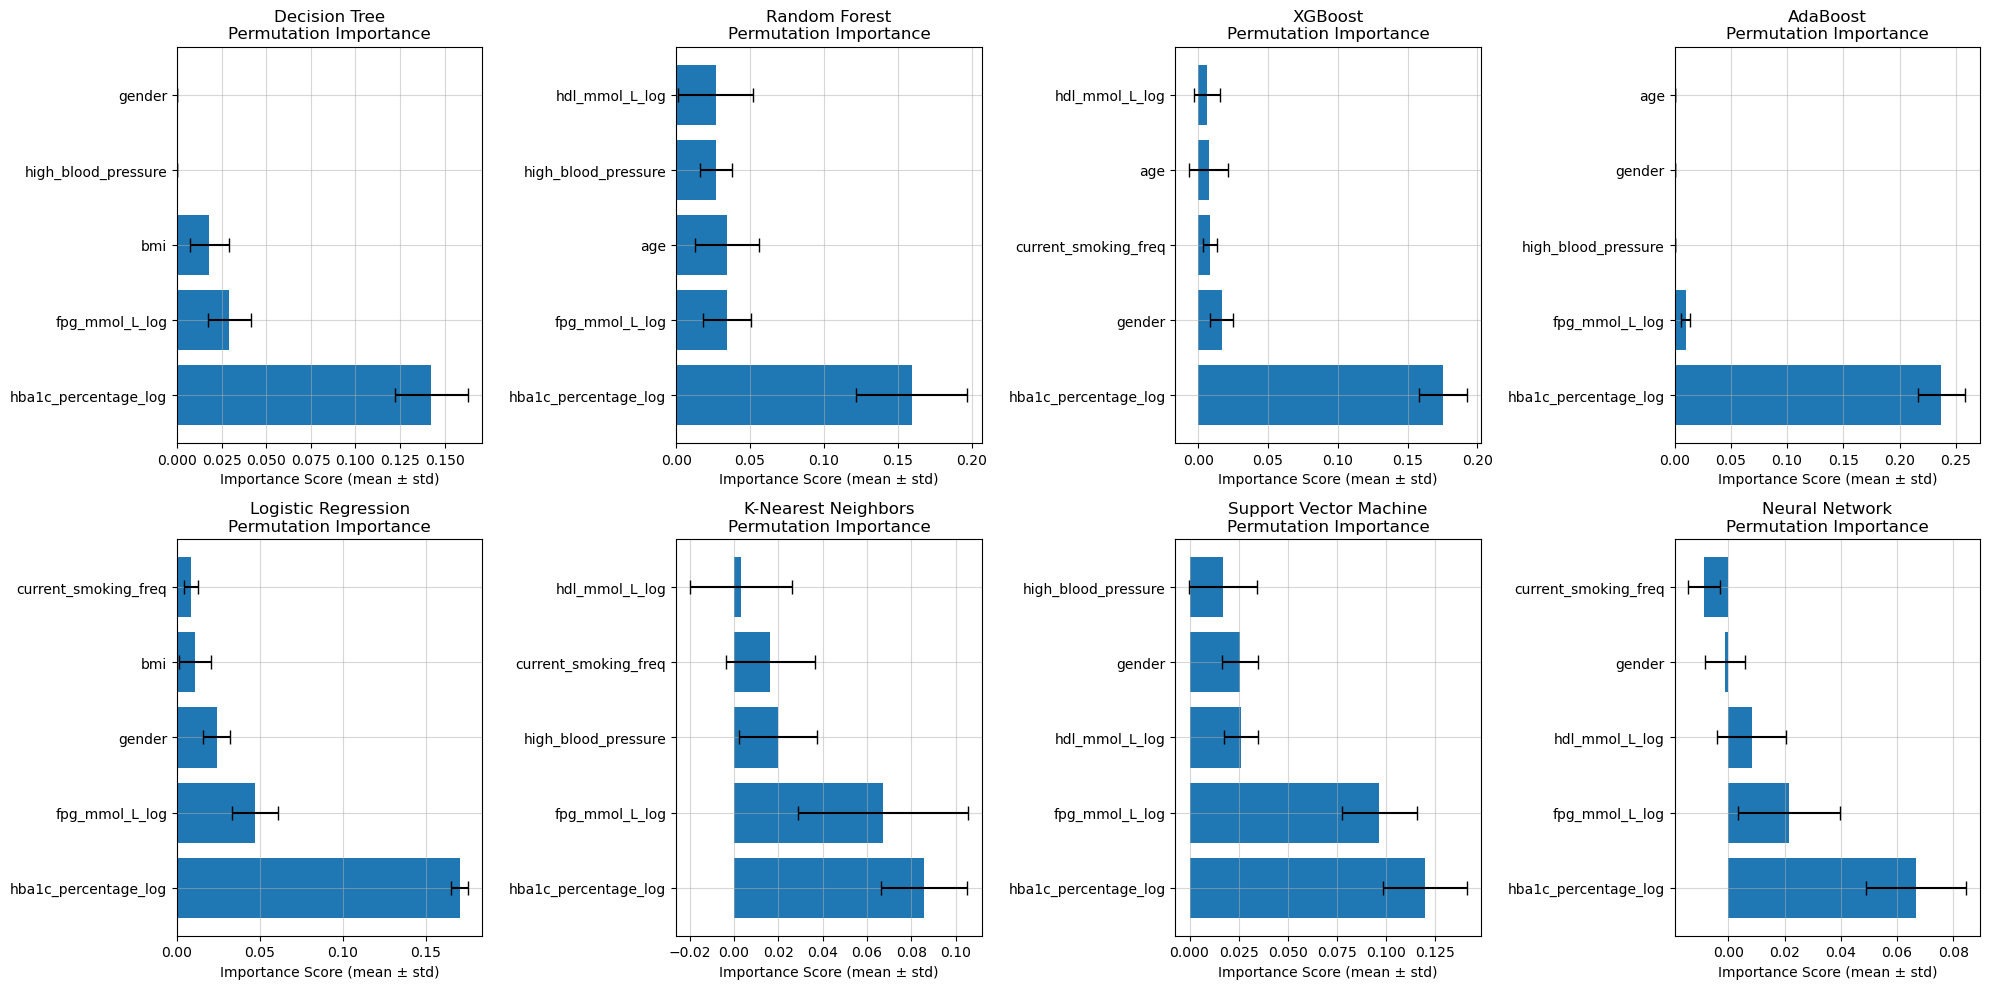

In [8]:
# Create visualisation of permutation importance for each model
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.ravel()

for idx, (model_name, importance_df) in enumerate(perm_importance_results.items()):
    ax = axes[idx]
    
    # Display the top 5 features only
    top_features = importance_df.head(5)
    
    ax.barh(range(len(top_features)), top_features["importance_mean"], xerr=top_features["importance_std"], capsize=5)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features["feature"])
    ax.set_xlabel("Importance Score (mean ± std)")
    ax.set_title(f"{model_name}\nPermutation Importance")
    ax.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [9]:
# Create comparison table
importance_comparison = pd.DataFrame()

for model_name, importance_df in perm_importance_results.items():
    importance_comparison[model_name] = importance_df.set_index("feature")["importance_mean"]

importance_comparison["Average"] = importance_comparison.mean(axis=1)
importance_comparison = importance_comparison.sort_values("Average", ascending=False)

print("Feature importance comparison across models:")
print(importance_comparison.round(4))

Feature importance comparison across models:
                      Decision Tree  Random Forest  XGBoost  AdaBoost  \
feature                                                                 
hba1c_percentage_log         0.1426         0.1593   0.1752    0.2373   
fpg_mmol_L_log               0.0293         0.0346   0.0034    0.0098   
gender                       0.0000         0.0195   0.0167    0.0000   
hdl_mmol_L_log               0.0000         0.0267   0.0065    0.0000   
current_smoking_freq         0.0000         0.0123   0.0087    0.0000   
bmi                          0.0182         0.0233   0.0031   -0.0017   
high_blood_pressure          0.0000         0.0270  -0.0012    0.0000   
age                         -0.0310         0.0345   0.0074    0.0000   

                      Logistic Regression  K-Nearest Neighbors  \
feature                                                          
hba1c_percentage_log               0.1704               0.0857   
fpg_mmol_L_log            

## SHAP (SHapeley Additive exPlanations)
A game theoretic approach to explain the output of any machine learning model, shopwing how each feautre contributes to push the model output from the base value

- explain shap

Reference : https://christophm.github.io/interpretable-ml-book/shap.html

In [10]:
import shap

In [11]:
# For Tree-based models (AdaBoost is not supported)
dt_explainer = shap.TreeExplainer(dt_model)
dt_shap_values = dt_explainer.shap_values(X_test)

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)

xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)

In [12]:
# For all other models, use KernelExplainer
background = shap.sample(X_train, 100)
background_scaled = shap.sample(X_train_scaled, 100)

adb_explainer = shap.KernelExplainer(adb_model.predict_proba, background)
adb_shap_values = adb_explainer.shap_values(X_test)

lgr_explainer = shap.KernelExplainer(lambda x: lgr_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
lgr_shap_values = lgr_explainer.shap_values(X_test)

knn_explainer = shap.KernelExplainer(lambda x: knn_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
knn_shap_values = knn_explainer.shap_values(X_test)

svc_explainer = shap.KernelExplainer(lambda x: svc_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
svc_shap_values = svc_explainer.shap_values(X_test)

nn_explainer = shap.KernelExplainer(lambda x: nn_model.predict(pd.DataFrame(x, columns=feature_names)), background_scaled)
nn_shap_values = nn_explainer.shap_values(X_test_scaled)


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/227 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
794/794 ━━━━━━

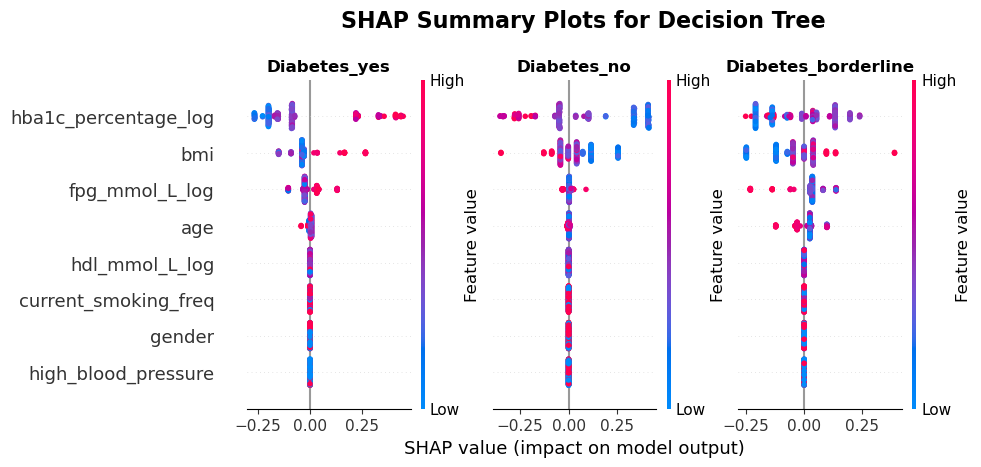

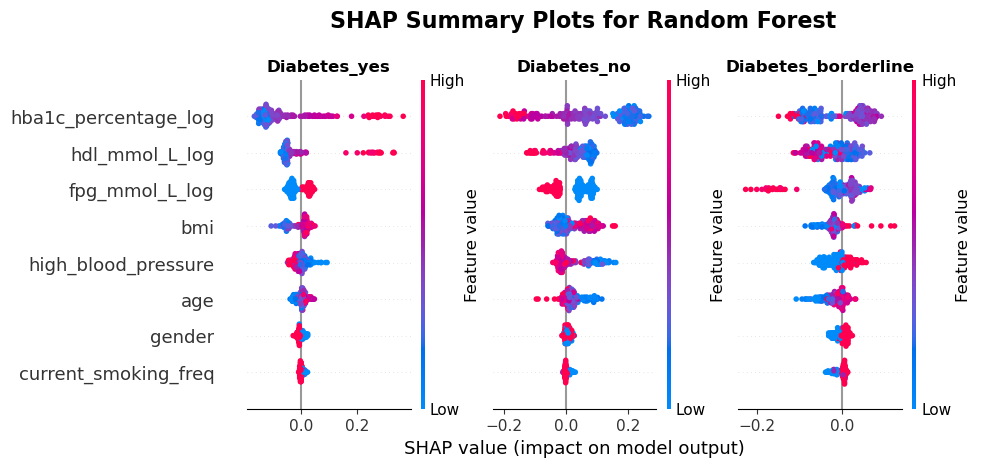

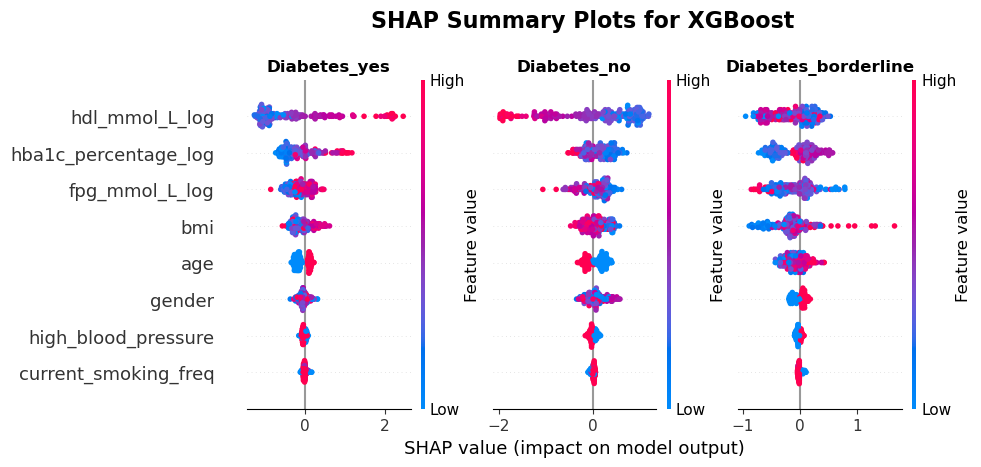

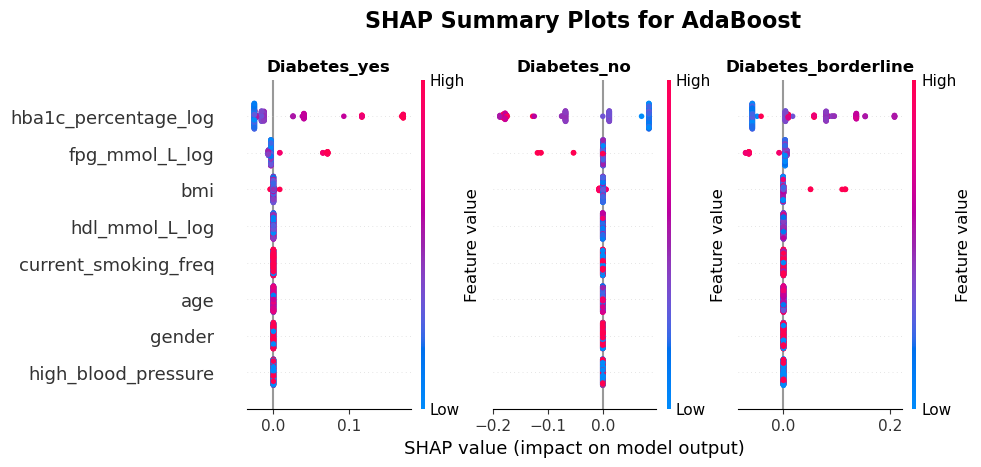

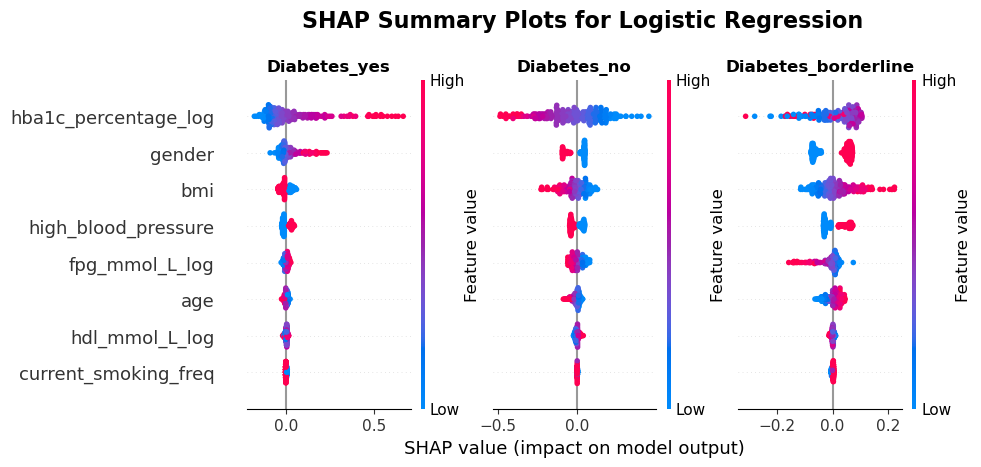

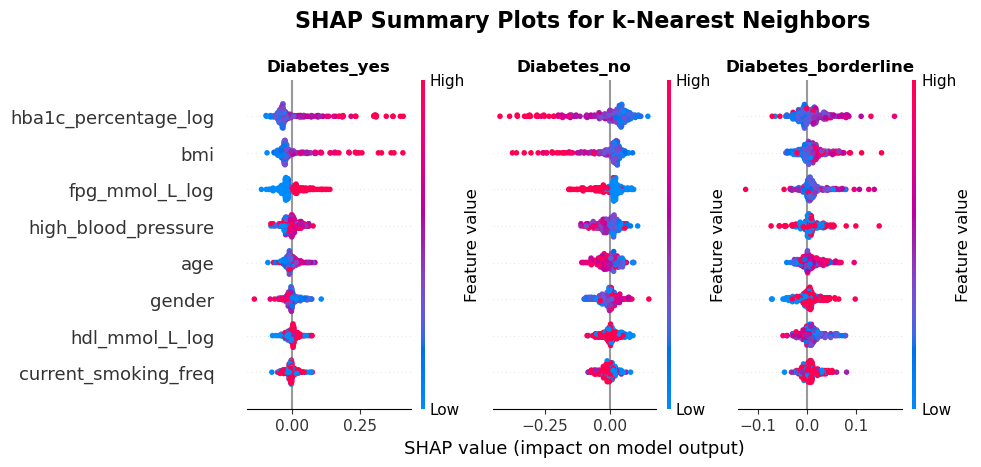

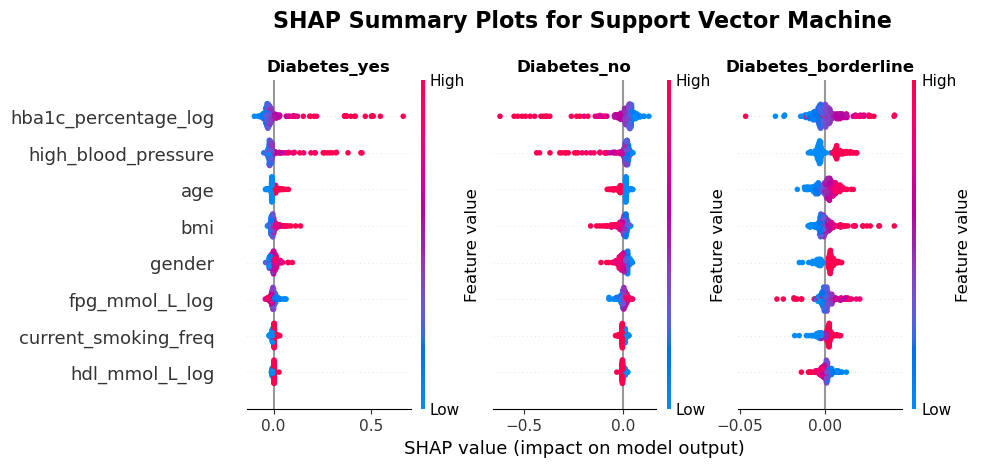

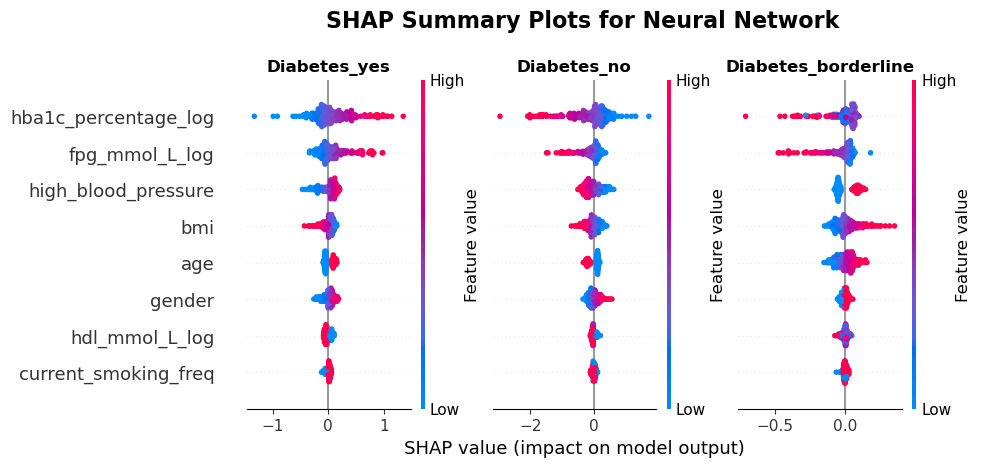

In [13]:
model_names = ["Decision Tree", "Random Forest", "XGBoost", "AdaBoost", "Logistic Regression", "k-Nearest Neighbors", "Support Vector Machine", "Neural Network"]
shap_values_list = [dt_shap_values, rf_shap_values, xgb_shap_values, adb_shap_values, lgr_shap_values, knn_shap_values, svc_shap_values, nn_shap_values]
class_names = ["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]

for model_idx, (shap_values, model_name) in enumerate(zip(shap_values_list, model_names)):
    fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    fig.suptitle(f"SHAP Summary Plots for {model_name}", fontweight="bold", y=1, fontsize=16)

    for class_idx in range(len(class_names)):
        ax = axes[class_idx]
        plt.sca(ax)
        
        X_data = X_test_scaled if model_name == "Neural Network" else X_test

        ax.set_title(f"{class_names[class_idx]}", fontweight="bold")
        shap.summary_plot(shap_values[:, :, class_idx], X_data, feature_names=feature_names, show=False)
        
        if class_idx != 1:
            ax.set_xlabel("")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.08, right=0.95, wspace=0.2)
    plt.show()